#**EXERCISE-2**

#**Que.1**
In the previous exercise, we compute the hessian matrix by $A^TA$ but after adding the regularization term the hessian becomes $A^TA +λI$. For $A^TA$ we can't assure the existence of the inverse of it. but the matrix  $A^TA+\lambda I$  is always invertible because  $A^TA$  is symmetric and by adding positive diagonal elements to symmetric matrix we assure the positiveness of eigenvalues.Hence, In this exercise the Inverse of hessian always exsit.

In general,we add regularized term to handle the over-fitting phenomenon.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from timeit import default_timer as timer
np.random.seed(1000)

In [2]:
A=np.random.randn(1000,10)

In [3]:
A.shape

(1000, 10)

In [4]:
epsilon=np.random.randn(1000,1)

In [5]:
epsilon.shape

(1000, 1)

In [6]:
x=[]
for i in range(1,11):
  if i%2==0:
    x.append(np.random.uniform(i,i+1))
  if i%2!=0:
    x.append(np.random.uniform(-i-1,-i))
print(x)

[-1.5598060982531905, 2.3304600657948655, -3.6795264016693583, 4.690106332295438, -5.791543695407358, 6.066830606319292, -7.250688337950498, 8.29645037615345, -9.919538982700145, 10.753574141825613]


In [7]:
x_bar=np.array(x)
x_bar=x_bar.reshape(10,1)


In [8]:
x_bar.shape

(10, 1)

In [9]:
print(x_bar)

[[-1.5598061 ]
 [ 2.33046007]
 [-3.6795264 ]
 [ 4.69010633]
 [-5.7915437 ]
 [ 6.06683061]
 [-7.25068834]
 [ 8.29645038]
 [-9.91953898]
 [10.75357414]]


In [10]:
A_x=A@x_bar

In [11]:
A_x.shape

(1000, 1)

In [12]:
np.matmul(A,x_bar).shape

(1000, 1)

In [13]:
y=A_x+epsilon

In [14]:
y.shape

(1000, 1)

In [15]:
def evalf(x,n,lamda):
  assert type(x) is np.ndarray and  len(x)==n
  f_val=np.linalg.norm(A@x - y)
  f_val=f_val**(2)
  f_val=(0.5)*f_val
  f_val=(lamda/2)*(x.T @ x)+f_val
  return f_val

In [16]:
def evalg(x,n,lamda):
  assert type(x) is np.ndarray 
  assert len(x) == n
  return np.add(np.matmul(A.T,(np.matmul(A, x) - y)), lamda*x)

In [17]:
x=np.random.rand(10,1)
evalf(x,10,1)

array([[253830.49324172]])

In [18]:
evalg(x,10,1).shape

(10, 1)

In [19]:
def evalh(x,n,lamda):
  assert type(x) is np.ndarray 
  assert len(x) == n 
  return (A.T @ A)+lamda*np.identity(n)

In [20]:
BACKTRACKING_LINE_SEARCH = 1

In [21]:
def compute_B_k(s, y, B_k, n):
  assert type(s) is np.ndarray and len(s) == n
  assert type(B_k) is np.ndarray and len(y) == n 
  mu = 1 / np.dot(np.squeeze(np.asarray(y)), np.squeeze(np.asarray(s)))
  I = np.identity(n)
  a_1 = np.outer(np.multiply(mu, s), y.T)
  a_2 = np.outer(np.multiply(mu, y), s.T)
  b_k = np.add(np.matmul(np.matmul(I - a_1, B_k), I - a_2), np.outer(np.multiply(mu, s), s.T) )
  return b_k

In [22]:
def compute_D_k(x,n,lamda):
  assert type(x) is np.ndarray and len(x) == n
  if np.linalg.det(evalh(x,n,lamda)) == 0:
    raise ValueError('Determinant of Hessian is zero')
  return np.linalg.inv(evalh(x,n,lamda))

In [23]:
def compute_steplength_backtracking_scaled_direction(x, gradf, alpha_start, rho, gamma, B_k,lamda): 
  assert type(x) is np.ndarray
  assert type(gradf) is np.ndarray
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  n = len(x)
  alpha = alpha_start
  p = - gradf 
  D_k = B_k
  while evalf(x + alpha*np.matmul(D_k,p), n,lamda) > evalf(x, n,lamda) + gamma * alpha* (np.matmul(np.matrix.transpose(gradf), np.matmul(D_k,p)) ):
    alpha = alpha * rho
  return alpha 

In [24]:
def find_minimizer_Newton(start_x, n, tol, line_search_type, lamda, *args):
  assert type(start_x) is np.ndarray and len(start_x) == n
  assert type(tol) is float and tol>=0 
  
  x = start_x
  g_x = evalg(x,n,lamda)
  h_x = evalh(x,n,lamda)
  x_iter = []
  if line_search_type == BACKTRACKING_LINE_SEARCH:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])

  k = 0
  step_length = 1.0
  while (np.linalg.norm(g_x) > tol): 
    D_k = np.linalg.inv(evalh(x, n,lamda))
    step_length = compute_steplength_backtracking_scaled_direction(x, g_x, alpha_start, rho, gamma, D_k,lamda)

    x = np.subtract(x, np.multiply(step_length,np.matmul(D_k, g_x))) #update x = x - step_length*g_x
    x_iter.append(x)
    k += 1 #increment iteration
    g_x = evalg(x, n,lamda) #compute gradient at new point
  return x, x_iter

In [25]:
def find_minimizer_BFGS_scaling(start_x, n, tol, line_search_type,lamda, *args):
 
  assert type(start_x) is np.ndarray and len(start_x) == n 
  assert type(tol) is float and tol>=0 
  
  x = start_x
  g_x = evalg(x,n,lamda)

  if line_search_type == BACKTRACKING_LINE_SEARCH:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])

  k = 0
  B_k = np.identity(n)
  x_prev = x
  x_itr = []
  while (np.linalg.norm(g_x) > tol):
    step_length = compute_steplength_backtracking_scaled_direction(x_prev, g_x, alpha_start, rho, gamma, B_k,lamda)
    x_new = np.subtract(x_prev, np.multiply(step_length, np.matmul(B_k,g_x))) 
    g_x = evalg(x_new,n,lamda)
    s = np.subtract(x_new, x_prev)
    y = np.subtract(evalg(x_new,n,lamda), evalg(x_prev,n,lamda)) 
    B_k = compute_B_k(s, y, B_k, n)
    x_prev = x_new
    k += 1
    x_itr.append(x_new)
  return x_new,x_itr

#Que.4

In [26]:
n=10
list_of_lamda=[0.001,0.01,0.1,1]
x_start=np.array([0 for i in range(10)]).reshape(10,1)
alpha_start=0.99
rho=0.5
gamma=0.5
my_tol= 1e-5
x_star_newton_list=[]
time_for_newton=[]
x_arr_for_lamda1=[]
x_arr_for_lamda2=[]
x_arr_for_lamda3=[]
x_arr_for_lamda4=[]
f_arr_for_lamda1=[]
f_arr_for_lamda2=[]
f_arr_for_lamda3=[]
f_arr_for_lamda4=[]
for lamda in list_of_lamda:
  print(f"\n\n\n for lamda= {lamda}")
  time1=timer()
  x_star_newton,x_iter=find_minimizer_Newton(x_start, n, my_tol, BACKTRACKING_LINE_SEARCH, lamda, alpha_start,rho,gamma)
  time2=timer()
  print(f"x_star={x_star_newton}\n time taken={time2-time1}")
  print(r'f(x_star)=',evalf(x_star_newton,n,lamda))
  x_star_newton_list.append(x_star_newton)
  time_for_newton.append(time2-time1)
  if lamda==0.001:
    for i in range(len(x_iter)-1):
      x_arr_for_lamda1.append(math.log(np.linalg.norm(x_iter[i] - x_star_newton)))
      f_arr_for_lamda1.append(math.log(np.linalg.norm(evalf(x_iter[i],n,lamda) - evalf(x_star_newton,n,lamda))))
  if lamda==0.01:
    for i in range(len(x_iter)-1):
      x_arr_for_lamda2.append(math.log(np.linalg.norm(x_iter[i] - x_star_newton)))
      f_arr_for_lamda2.append(math.log(np.linalg.norm(evalf(x_iter[i],n,lamda) - evalf(x_star_newton,n,lamda))))
  if lamda==0.1:
    for i in range(len(x_iter)-1):
      x_arr_for_lamda3.append(math.log(np.linalg.norm(x_iter[i] - x_star_newton)))
      f_arr_for_lamda3.append(math.log(np.linalg.norm(evalf(x_iter[i],n,lamda) - evalf(x_star_newton,n,lamda))))
  if lamda==1:
    for i in range(len(x_iter)-1):
      x_arr_for_lamda4.append(math.log(np.linalg.norm(x_iter[i] - x_star_newton)))
      f_arr_for_lamda4.append(math.log(np.linalg.norm(evalf(x_iter[i],n,lamda) - evalf(x_star_newton,n,lamda))))






 for lamda= 0.001
x_star=[[-1.52615618]
 [ 2.3593343 ]
 [-3.71408397]
 [ 4.65508056]
 [-5.7922779 ]
 [ 6.05589718]
 [-7.25518231]
 [ 8.32368594]
 [-9.87347598]
 [10.71877202]]
 time taken=0.00915600700000141
f(x_star)= [[504.820307]]



 for lamda= 0.01
x_star=[[-1.52614455]
 [ 2.35932028]
 [-3.71405267]
 [ 4.65503097]
 [-5.79223521]
 [ 6.05584892]
 [-7.25512314]
 [ 8.32362251]
 [-9.87339781]
 [10.71868531]]
 time taken=0.0019349479999846153
f(x_star)= [[506.83576522]]



 for lamda= 0.1
x_star=[[-1.52602828]
 [ 2.35918007]
 [-3.71373963]
 [ 4.65453516]
 [-5.79180829]
 [ 6.05536638]
 [-7.25453148]
 [ 8.3229883 ]
 [-9.87261621]
 [10.71781829]]
 time taken=0.0018801550000091538
f(x_star)= [[526.98856754]]



 for lamda= 1
x_star=[[-1.52486663]
 [ 2.35777873]
 [-3.71061221]
 [ 4.64958266]
 [-5.78754243]
 [ 6.05054512]
 [-7.24862026]
 [ 8.31665145]
 [-9.86480705]
 [10.70915597]]
 time taken=0.004582112000008465
f(x_star)= [[728.33876802]]


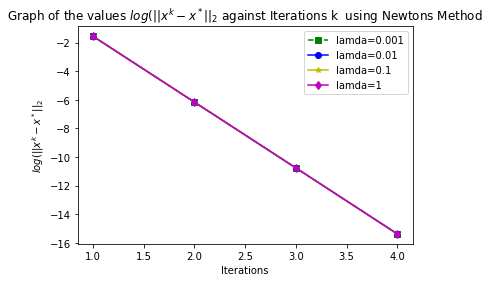

In [27]:
plt.plot([i+1 for i in np.arange(len(x_arr_for_lamda1))], x_arr_for_lamda1,"gs--")
plt.plot([i+1 for i in np.arange(len(x_arr_for_lamda2))], x_arr_for_lamda2,"b-o")
plt.plot([i+1 for i in np.arange(len(x_arr_for_lamda3))], x_arr_for_lamda3,"y*-")
plt.plot([i+1 for i in np.arange(len(x_arr_for_lamda4))], x_arr_for_lamda4,"md-")
plt.title(r'Graph of the values $log(||x^k - x^*||_2$ against Iterations k  using Newtons Method')
plt.xlabel('Iterations')
plt.ylabel(r'$log(||x^k - x^*||_2$')
plt.legend(["lamda=0.001","lamda=0.01","lamda=0.1","lamda=1"])
plt.show()

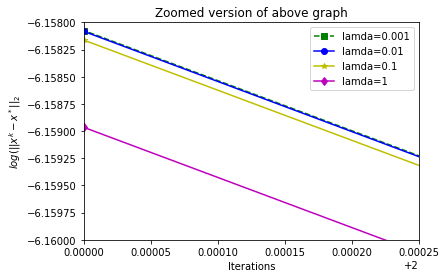

In [28]:
plt.plot([i+1 for i in np.arange(len(x_arr_for_lamda1))], x_arr_for_lamda1,"gs--")
plt.plot([i+1 for i in np.arange(len(x_arr_for_lamda2))], x_arr_for_lamda2,"b-o")
plt.plot([i+1 for i in np.arange(len(x_arr_for_lamda3))], x_arr_for_lamda3,"y*-")
plt.plot([i+1 for i in np.arange(len(x_arr_for_lamda4))], x_arr_for_lamda4,"md-")
plt.title('Zoomed version of above graph')
plt.xlabel('Iterations')
plt.ylabel(r'$log(||x^k - x^*||_2$')
plt.legend(["lamda=0.001","lamda=0.01","lamda=0.1","lamda=1"])
plt.xlim([2,2.00025])
plt.ylim([-6.16,-6.1580])
plt.show()

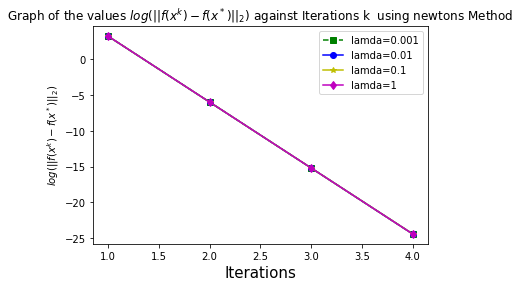

In [29]:
plt.plot([i+1 for i in np.arange(len(f_arr_for_lamda1))], f_arr_for_lamda1,"gs--")
plt.plot([i+1 for i in np.arange(len(f_arr_for_lamda2))], f_arr_for_lamda2,"b-o")
plt.plot([i+1 for i in np.arange(len(f_arr_for_lamda3))], f_arr_for_lamda3,"y*-")
plt.plot([i+1 for i in np.arange(len(f_arr_for_lamda4))], f_arr_for_lamda4,"md-")
plt.title(r'Graph of the values $log(||f(x^k) - f(x^*)||_2)$ against Iterations k  using newtons Method')
plt.xlabel(r'Iterations',fontsize=15)
plt.ylabel(r'$log(||f(x^k) - f(x^*)||_2)$')
plt.legend(["lamda=0.001","lamda=0.01","lamda=0.1","lamda=1"])
plt.show()

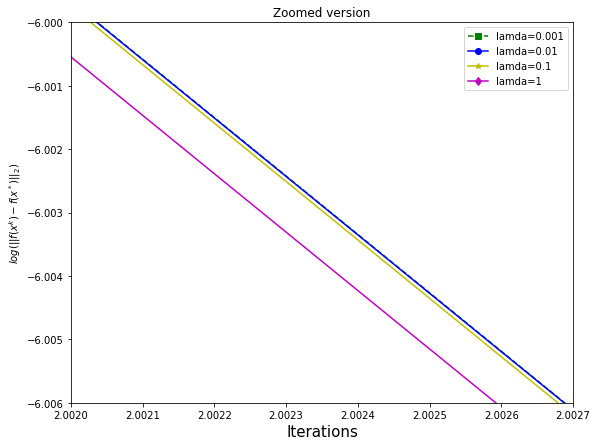

In [30]:
plt.figure(figsize=(9,7))
plt.plot([i+1 for i in np.arange(len(f_arr_for_lamda1))], f_arr_for_lamda1,"gs--")
plt.plot([i+1 for i in np.arange(len(f_arr_for_lamda2))], f_arr_for_lamda2,"b-o")
plt.plot([i+1 for i in np.arange(len(f_arr_for_lamda3))], f_arr_for_lamda3,"y*-")
plt.plot([i+1 for i in np.arange(len(f_arr_for_lamda4))], f_arr_for_lamda4,"md-")
plt.title("Zoomed version")
plt.xlim([2.002,2.0027])
plt.ylim([-6.006,-6])
plt.xlabel(r'Iterations',fontsize=15)
plt.ylabel(r'$log(||f(x^k) - f(x^*)||_2)$')
plt.legend(["lamda=0.001","lamda=0.01","lamda=0.1","lamda=1"])
plt.show()

The condition of Q-Linear is :$\frac{||x^{k+1} - x^||_2}{||x^{k} - x^||_2}\leq r$, Where $r\in(0,1)$

taking log both side, we get
$$log(||x^{k+1} - x^||_2)-log(||x^k - x^||_2)\leq log(r)$$


Since $r\in (0,1)$

hence $log(r)< 0$ 

Hence the condition of Q-Linear becomes:

$$log(||x^{k+1} - x^||_2)-log(||x^k - x^||_2)\leq 0$$

From the above plots, we can observe that:

$log(||x^{k+1} - x^||_2)-log(||x^k - x^||_2)$ is negative.


Hence, we can say that the Convergence of the function is Q-Linear.

**Convergence rate is almost similar for each value of lamda.**

#Que.5

In [31]:
n=10
list_of_lamda=[0.001,0.01,0.1,1]
x_start=np.array([0 for i in range(10)]).reshape(10,1)
alpha_start=0.99
rho=0.5
gamma=0.5
my_tol= 1e-5
x_star_bfgs_list=[]
time_for_bfgs=[]
x_arr_for_lamda1=[]
x_arr_for_lamda2=[]
x_arr_for_lamda3=[]
x_arr_for_lamda4=[]
f_arr_for_lamda1=[]
f_arr_for_lamda2=[]
f_arr_for_lamda3=[]
f_arr_for_lamda4=[]
for lamda in list_of_lamda:
  print(f"\n\n\n for lamda= {lamda}")
  time1=timer()
  x_star_bfgs,x_iter=find_minimizer_BFGS_scaling(x_start, n, my_tol, BACKTRACKING_LINE_SEARCH, lamda, alpha_start,rho,gamma)
  time2=timer()
  print(f"x_star={x_star_bfgs}\n time taken={time2-time1}")
  print(r"f(x_star)=",evalf(x_star_bfgs,n,lamda))
  time_for_bfgs.append(time2-time1)
  x_star_bfgs_list.append(x_star_bfgs)
  if lamda==0.001:
    for i in range(len(x_iter)-1):
      x_arr_for_lamda1.append(math.log(np.linalg.norm(x_iter[i] - x_star_bfgs)))
      f_arr_for_lamda1.append(math.log(np.linalg.norm(evalf(x_iter[i],n,lamda) - evalf(x_star_bfgs,n,lamda))))
  if lamda==0.01:
    for i in range(len(x_iter)-1):
      x_arr_for_lamda2.append(math.log(np.linalg.norm(x_iter[i] - x_star_bfgs)))
      f_arr_for_lamda2.append(math.log(np.linalg.norm(evalf(x_iter[i],n,lamda) - evalf(x_star_bfgs,n,lamda))))
  if lamda==0.1:
    for i in range(len(x_iter)-1):
      x_arr_for_lamda3.append(math.log(np.linalg.norm(x_iter[i] - x_star_bfgs)))
      f_arr_for_lamda3.append(math.log(np.linalg.norm(evalf(x_iter[i],n,lamda) - evalf(x_star_bfgs,n,lamda))))
  if lamda==1:
    for i in range(len(x_iter)-1):
      x_arr_for_lamda4.append(math.log(np.linalg.norm(x_iter[i] - x_star_bfgs)))
      f_arr_for_lamda4.append(math.log(np.linalg.norm(evalf(x_iter[i],n,lamda) - evalf(x_star_bfgs,n,lamda))))




 for lamda= 0.001
x_star=[[-1.52615618]
 [ 2.3593343 ]
 [-3.71408397]
 [ 4.65508056]
 [-5.7922779 ]
 [ 6.05589718]
 [-7.25518231]
 [ 8.32368594]
 [-9.87347598]
 [10.71877202]]
 time taken=0.03676129199999423
f(x_star)= [[504.820307]]



 for lamda= 0.01
x_star=[[-1.52614455]
 [ 2.35932028]
 [-3.71405267]
 [ 4.65503097]
 [-5.79223521]
 [ 6.05584892]
 [-7.25512314]
 [ 8.32362251]
 [-9.87339781]
 [10.71868531]]
 time taken=0.019226137000003973
f(x_star)= [[506.83576522]]



 for lamda= 0.1
x_star=[[-1.52602828]
 [ 2.35918007]
 [-3.71373963]
 [ 4.65453516]
 [-5.79180829]
 [ 6.05536638]
 [-7.25453148]
 [ 8.3229883 ]
 [-9.87261621]
 [10.71781829]]
 time taken=0.01651405800001271
f(x_star)= [[526.98856754]]



 for lamda= 1
x_star=[[-1.52486663]
 [ 2.35777873]
 [-3.71061221]
 [ 4.64958266]
 [-5.78754243]
 [ 6.05054512]
 [-7.24862026]
 [ 8.31665145]
 [-9.86480705]
 [10.70915597]]
 time taken=0.016441430000014634
f(x_star)= [[728.33876802]]


In [32]:
time_for_bfgs

[0.03676129199999423,
 0.019226137000003973,
 0.01651405800001271,
 0.016441430000014634]

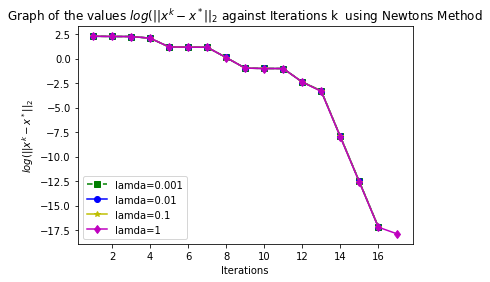

In [33]:
plt.plot([i+1 for i in np.arange(len(x_arr_for_lamda1))], x_arr_for_lamda1,"gs--")
plt.plot([i+1 for i in np.arange(len(x_arr_for_lamda2))], x_arr_for_lamda2,"b-o")
plt.plot([i+1 for i in np.arange(len(x_arr_for_lamda3))], x_arr_for_lamda3,"y*-")
plt.plot([i+1 for i in np.arange(len(x_arr_for_lamda4))], x_arr_for_lamda4,"md-")
plt.title(r'Graph of the values $log(||x^k - x^*||_2$ against Iterations k  using Newtons Method')
plt.xlabel('Iterations')
plt.ylabel(r'$log(||x^k - x^*||_2$')
plt.legend(["lamda=0.001","lamda=0.01","lamda=0.1","lamda=1"])
plt.show()

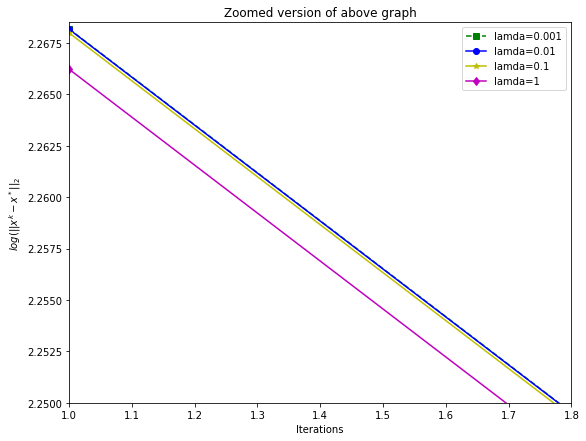

In [34]:
plt.figure(figsize=(9,7))
plt.plot([i+1 for i in np.arange(len(x_arr_for_lamda1))], x_arr_for_lamda1,"gs--")
plt.plot([i+1 for i in np.arange(len(x_arr_for_lamda2))], x_arr_for_lamda2,"b-o")
plt.plot([i+1 for i in np.arange(len(x_arr_for_lamda3))], x_arr_for_lamda3,"y*-")
plt.plot([i+1 for i in np.arange(len(x_arr_for_lamda4))], x_arr_for_lamda4,"md-")
plt.title('Zoomed version of above graph')
plt.xlim([1,1.8])
plt.ylim([2.25,2.2685])
plt.xlabel('Iterations')
plt.ylabel(r'$log(||x^k - x^*||_2$')
plt.legend(["lamda=0.001","lamda=0.01","lamda=0.1","lamda=1"])
plt.show()

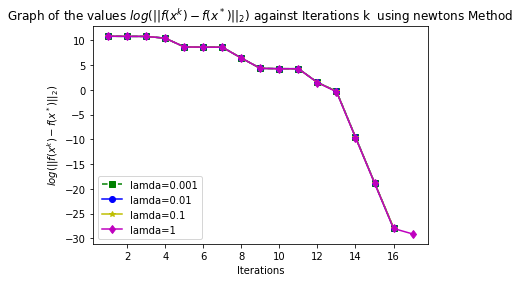

In [35]:
plt.plot([i+1 for i in np.arange(len(f_arr_for_lamda1))], f_arr_for_lamda1,"gs--")
plt.plot([i+1 for i in np.arange(len(f_arr_for_lamda2))], f_arr_for_lamda2,"b-o")
plt.plot([i+1 for i in np.arange(len(f_arr_for_lamda3))], f_arr_for_lamda3,"y*-")
plt.plot([i+1 for i in np.arange(len(f_arr_for_lamda4))], f_arr_for_lamda4,"md-")
plt.title(r'Graph of the values $log(||f(x^k) - f(x^*)||_2)$ against Iterations k  using newtons Method')
plt.xlabel('Iterations')
plt.ylabel(r'$log(||f(x^k) - f(x^*)||_2)$')
plt.legend(["lamda=0.001","lamda=0.01","lamda=0.1","lamda=1"])
plt.show()

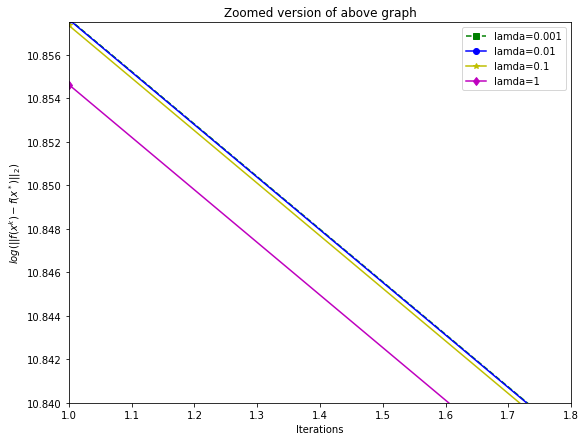

In [36]:
plt.figure(figsize=(9,7))
plt.plot([i+1 for i in np.arange(len(f_arr_for_lamda1))], f_arr_for_lamda1,"gs--")
plt.plot([i+1 for i in np.arange(len(f_arr_for_lamda2))], f_arr_for_lamda2,"b-o")
plt.plot([i+1 for i in np.arange(len(f_arr_for_lamda3))], f_arr_for_lamda3,"y*-")
plt.plot([i+1 for i in np.arange(len(f_arr_for_lamda4))], f_arr_for_lamda4,"md-")
plt.title('Zoomed version of above graph')
plt.xlim([1,1.8])
plt.ylim([10.84,10.8575])
plt.xlabel('Iterations')
plt.ylabel(r'$log(||f(x^k) - f(x^*)||_2)$')
plt.legend(["lamda=0.001","lamda=0.01","lamda=0.1","lamda=1"])
plt.show()

From the above plots, we can observe that:

$log(||x^{k+1} - x^||_2)-log(||x^k - x^||_2)$ is negative.


Hence, we can say that the Convergence of the function is Q-Linear.

**Convergence rate is almost similar for each lamda** 

#Que.6

In [37]:
from tabulate import tabulate

In [38]:
my_data=[[list_of_lamda[i],time_for_newton[i],time_for_bfgs[i],x_star_newton_list[i],x_star_bfgs_list[i]] for i in range(len(list_of_lamda))]
head=["Value of lamda","time taken by newton","time taken by bfgs","x star for newton","x star value for bfgs"]
print(tabulate(my_data, headers=head, tablefmt="grid"))

+------------------+------------------------+----------------------+---------------------+-------------------------+
|   Value of lamda |   time taken by newton |   time taken by bfgs | x star for newton   | x star value for bfgs   |
+==================+========================+======================+=====================+=========================+
|            0.001 |             0.00915601 |            0.0367613 | [[-1.52615618]      | [[-1.52615618]          |
|                  |                        |                      |  [ 2.3593343 ]      |  [ 2.3593343 ]          |
|                  |                        |                      |  [-3.71408397]      |  [-3.71408397]          |
|                  |                        |                      |  [ 4.65508056]      |  [ 4.65508056]          |
|                  |                        |                      |  [-5.7922779 ]      |  [-5.7922779 ]          |
|                  |                        |                   

In the above table, we can see that the newton's method is taking less time as compare to BFGS method for different values of lamda. the newtons method is 10 times faster than the BFGS method.